# **Importing the libraries**

In [ ]:
import pandas as pd 
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import svm
import itertools
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data loading** 

In [ ]:
data = pd.read_csv('drive/MyDrive/creditcard.csv')
df = pd.DataFrame(data)                                          

# **Visualising the data**

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.describe() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


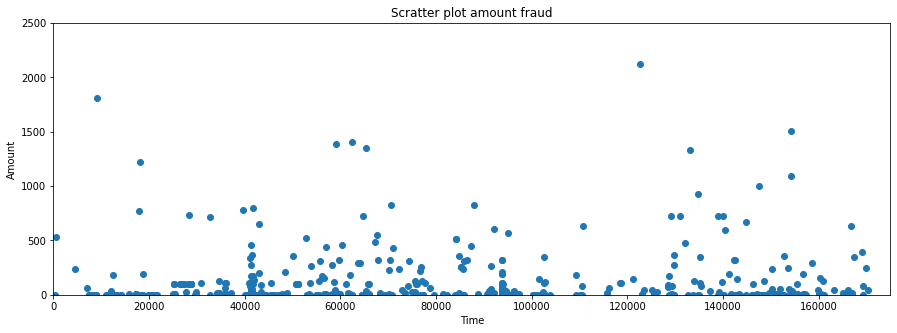

In [ ]:
df_fraud = df[df['Class'] == 1] # Recovery of fraud data
plt.figure(figsize=(15,5))
plt.scatter(df_fraud['Time'], df_fraud['Amount']) # Display fraud amounts according to their time
plt.title('Scratter plot amount fraud')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.xlim([0,175000])
plt.ylim([0,2500])
plt.show()

We notive, first of all, the time doesn't impact the frequency of frauds. Moreover, the majority of frauds are small amounts.

In [ ]:
nb_big_fraud = df_fraud[df_fraud['Amount'] > 1000].shape[0]                                                     
print('There are only {} frauds where the amount was bigger than 1000 over {} frauds'.format(str(nb_big_fraud),str(df_fraud.shape[0]) ))

There are only 9 frauds where the amount was bigger than 1000 over 492 frauds


# **Checking for unbalanced or balanced data**

In [ ]:
number_fraud = len(data[data.Class == 1])
number_no_fraud = len(data[data.Class == 0])
print('There are only {}  frauds in the original dataset, even though there are {} no frauds in the dataset.'.format(str(number_fraud),str(number_no_fraud)))

There are only 492  frauds in the original dataset, even though there are 284315 no frauds in the dataset.


We can clearly see that the dataset is unbalanced here . This is because the n(frauds) <<<<<<<< n(no fraud) . Thus , the classifier might take very less or nothing of the no fraud class into the consideration . 

This must be solved using resampling of the data .

In [ ]:
print("The accuracy of the classifier then would be : {} which is the number of good classification over the number of tuple to classify".format(str((284315-492)/284315)))

The accuracy of the classifier then would be : 0.998269524998681 which is the number of good classification over the number of tuple to classify


This problem can be solved using either the oversampling or the undersampling method.
The undersampling principle should be used only if we are sure of the fact that the selected few tuples (non-fraud) completely represents the entire non-fraud class very well .  

# **Correlation of features**

In [ ]:
df_corr = df.corr() 

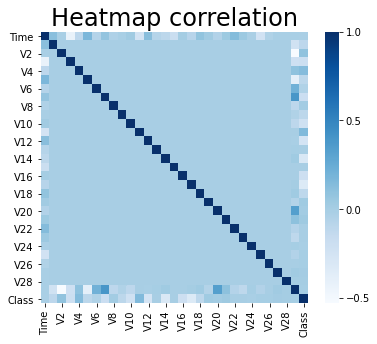

In [ ]:
plt.figure(figsize=(6,5))
seaborn.heatmap(df_corr, cmap='Blues') 
seaborn.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

From the above heat map we can easily conclude that there are very few correlated features in it .
This waves or points towards the presence of a PCA being applied on this .  

However in this case we were already aware of the fact that a PCA was previously performed. 

If the dimension reduction is applied effectively then PCA isn't computed in the most effective way. Another way to say this is that no dimensionality reduction should be applied on a dataset on which a PCA was computed correctly.

In [ ]:
rank = df_corr['Class'] # Retrieving the correlation coefficients per feature in relation to the feature class
df_rank = pd.DataFrame(rank) 
df_rank = np.abs(df_rank).sort_values(by='Class',ascending=False) # Ranking the absolute values of the coefficients in descending order
df_rank.dropna(inplace=True) # Removing Missing Data

# **Resampling the data**

This can be done in two ways :-

#### OVERSAMPLING

One way to do oversampling is to replicate the under-represented class tuples until we attain a correct proportion between the class.

However as we don't have an infinite amount of time or the patience, we are going to run the classifier with the undersampled training data.

#### UNDERSAMPLING

In [ ]:
df_train_all = df[0:150000] 
df_train_1 = df_train_all[df_train_all['Class'] == 1] 
df_train_0 = df_train_all[df_train_all['Class'] == 0]
print('In this dataset, we have {} frauds so we need to take a similar number of non-fraud'.format(len(df_train_1)))

df_sample=df_train_0.sample(300)
df_train = df_train_1.append(df_sample) # We gather the frauds with the no frauds. 
df_train = df_train.sample(frac=1) # Then we mix our dataset

In this dataset, we have 293 frauds so we need to take a similar number of non-fraud


In [ ]:
X_train = df_train.drop(['Time', 'Class'],axis=1) # We drop the features which are useless like Time ,the labels 
y_train = df_train['Class'] # We create our label
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [ ]:
#with all the test dataset to see if the model learn correctly
df_test_all = df[150000:]

X_test_all = df_test_all.drop(['Time', 'Class'],axis=1)
y_test_all = df_test_all['Class']
X_test_all = np.asarray(X_test_all)
y_test_all = np.asarray(y_test_all)

Then we define training and testing set after applying a dimension reduction to illustrate the fact that nothing will be gained because a PCA was previously computed

In [ ]:
X_train_rank = df_train[df_rank.index[1:11]] # We take the first ten ranked features
X_train_rank = np.asarray(X_train_rank)

In [ ]:
#with all the test dataset to see if the model learn correctly
X_test_all_rank = df_test_all[df_rank.index[1:11]]
X_test_all_rank = np.asarray(X_test_all_rank)
y_test_all = np.asarray(y_test_all)

# **Confusion Matrix**

In [ ]:
class_names=np.array(['0','1']) # Binary label

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# **Applying the SVM**

We use the SVM model classifier in the scikit-learn library.

In [ ]:
classifier = svm.SVC(kernel='linear') 

#**Training the model**

In [ ]:
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# **Testing the model**

In [ ]:
prediction_SVM_all = classifier.predict(X_test_all)

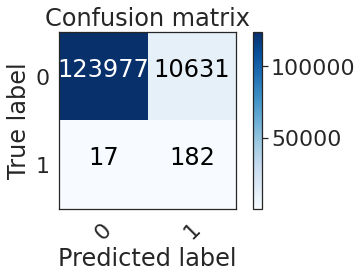

In [ ]:
cm = confusion_matrix(y_test_all, prediction_SVM_all)
plot_confusion_matrix(cm,class_names)

In this case we are gonna try to minimize the number of errors in our prediction results. Errors are on the anti-diagonal of the confusion matrix.  But we can infer that being wrong about an actual fraud is far worse than being wrong about a non-fraud transaction. 

Thus using accuracy as the only classification criterion is not a good approach. 

In the remaining part we will consider our criterion precision on the real fraud as 4 times important as the general accuracy.


In [ ]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.91586089221244


In [ ]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 182 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.914572864321608
the accuracy is : 0.9210130037757683


 # Models Rank

There is a need to compute the fit method again, as the dimension of the tuples to predict went from 29 to 10 because of the dimension reduction

In [ ]:
classifier.fit(X_train_rank, y_train) # Then we train our model, with our balanced data train.
prediction_SVM = classifier.predict(X_test_all_rank) #And finally, we predict our data test.

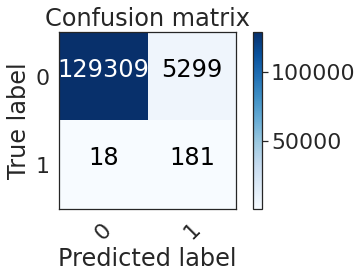

In [ ]:
cm = confusion_matrix(y_test_all, prediction_SVM)
plot_confusion_matrix(cm,class_names)

In [ ]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.9197498765497356


In [ ]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 181 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.9095477386934674
the accuracy is : 0.9605584279748084


We can see that the study using the reduced data is far from unrelevant, which means that the last step of the previously computed PCA could have been done in a more efficient way. Indeed one of the main question we have with the PCA once we calculated the principals components direction, is how many of this component are we gonna keep. This means that some of the 30 dimensions are do not discriminate classes that much.

# Re-balanced class weigh :

In this previously used SVM model, the weigh of each class was the same, which means that missing a fraud is as bad as misjudging a non-fraud. The objective, for a bank, is to maximize the number of detected frauds! Even if it means considering more non-fraud tuple as fraudulent operation. So, we need to minimize the False positives : the number of no detected frauds.

Indeed, by modifying the class_weight parameter, we can chose which class to give more importance during the training phase. In this case, the class_1 which describes the fraudulent operations will be considered more important than the class_0 (non-fraud operation). However, in this case we will give more importance to the class_0 due to the large number of misclassed non-fraud operation. Of course the goal is to lose as little effective fraud as possible in the process.


In [ ]:
classifier_b = svm.SVC(kernel='linear',class_weight={0:0.60, 1:0.40})

In [ ]:
classifier_b.fit(X_train, y_train) # Then we train our model, with our balanced data train.

SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 0.6, 1: 0.4},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

# Testing the model

In [ ]:
prediction_SVM_b_all = classifier_b.predict(X_test_all) #We predict all the data set.

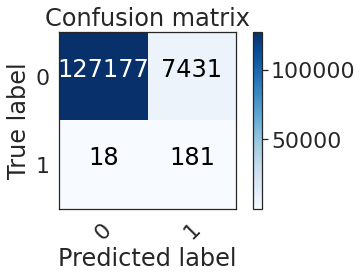

In [ ]:
cm = confusion_matrix(y_test_all, prediction_SVM_b_all)
plot_confusion_matrix(cm,class_names)

In [ ]:
print('Our criterion give a result of {}' .format( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.9165868360548058


In [ ]:
print('We have detected {} frauds / {} total frauds.'.format((cm[1][1]) ,(cm[1][1]+cm[1][0])))
print('Probability to detect a fraud is {}'.format(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : {} ".format((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 181 frauds / 199 total frauds.
Probability to detect a fraud is 0.9095477386934674
the accuracy is : 0.9447432255001594 


 # Models Rank

In [ ]:
classifier_b.fit(X_train_rank, y_train) # Then we train our model, with our balanced data train.
prediction_SVM = classifier_b.predict(X_test_all_rank) #And finally, we predict our data test.

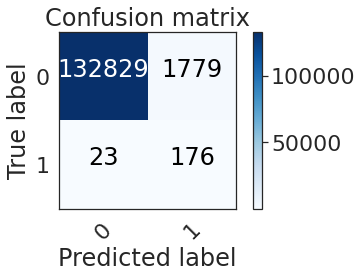

In [ ]:
cm = confusion_matrix(y_test_all, prediction_SVM)
plot_confusion_matrix(cm,class_names)

In [ ]:
certanity = (((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5)

In [ ]:
print('Our criterion give a result of {}'.format(certanity))

Our criterion give a result of 0.9048642367668529


In [ ]:
probability = (cm[1][1])/(cm[1][1]+cm[1][0])
accuracy = (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))

In [ ]:
print('We have detected {} frauds / {} total frauds.'.format(str(cm[1][1]) ,str(cm[1][1]+cm[1][0])))
print('Probability of detecting fraud {} '.format(probability))
print("the accuracy is : {}".format(accuracy))

We have detected 176 frauds / 199 total frauds.
Probability of detecting fraud 0.8844221105527639 
the accuracy is : 0.9866327416232095


# Changing the Kernel

## Polynomial Kernel

In [ ]:
classifier_b = svm.SVC(kernel='poly',class_weight={0:0.60, 1:0.40})

In [ ]:
classifier_b.fit(X_train, y_train) # Then we train our model, with our balanced data train.

SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 0.6, 1: 0.4},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
prediction_SVM_b_all = classifier_b.predict(X_test_all) #We predict all the data set.

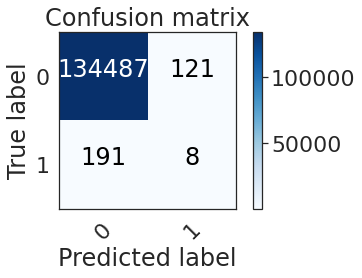

In [ ]:
cm = confusion_matrix(y_test_all, prediction_SVM_b_all)
plot_confusion_matrix(cm,class_names)

In [ ]:
print('Our criterion give a result of {}' .format( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.2316979200452327


In [ ]:
print('We have detected {} frauds / {} total frauds.'.format((cm[1][1]) ,(cm[1][1]+cm[1][0])))
print('Probability to detect a fraud is {}'.format(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : {} ".format((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 8 frauds / 199 total frauds.
Probability to detect a fraud is 0.04020100502512563
the accuracy is : 0.9976855801256611 


## RBF Kerne

In [ ]:
classifier_b = svm.SVC(kernel='rbf',class_weight={0:0.60, 1:0.40})

In [ ]:
classifier_b.fit(X_train, y_train) # Then we train our model, with our balanced data train.

SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 0.6, 1: 0.4},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
prediction_SVM_b_all = classifier_b.predict(X_test_all) #We predict all the data set.

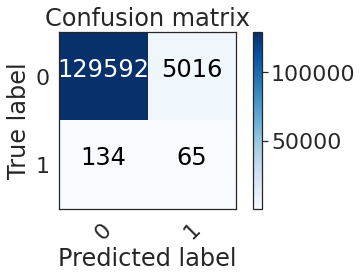

In [ ]:
cm = confusion_matrix(y_test_all, prediction_SVM_b_all)
plot_confusion_matrix(cm,class_names)

In [ ]:
print('Our criterion give a result of {}' .format( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.45366597987303126


In [ ]:
print('We have detected {} frauds / {} total frauds.'.format((cm[1][1]) ,(cm[1][1]+cm[1][0])))
print('Probability to detect a fraud is {}'.format(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : {} ".format((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 65 frauds / 199 total frauds.
Probability to detect a fraud is 0.32663316582914576
the accuracy is : 0.9617972360485731 


## Sigmoid Kernel

In [ ]:
classifier_b = svm.SVC(kernel='sigmoid',class_weight={0:0.60, 1:0.40})

In [ ]:
classifier_b.fit(X_train, y_train) # Then we train our model, with our balanced data train.

SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 0.6, 1: 0.4},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
prediction_SVM_b_all = classifier_b.predict(X_test_all) #We predict all the data set.

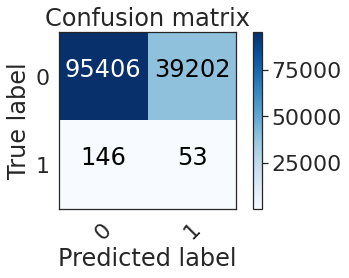

In [ ]:
cm = confusion_matrix(y_test_all, prediction_SVM_b_all)
plot_confusion_matrix(cm,class_names)

In [ ]:
print('Our criterion give a result of {}' .format( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.3546885361104185


In [ ]:
print('We have detected {} frauds / {} total frauds.'.format((cm[1][1]) ,(cm[1][1]+cm[1][0])))
print('Probability to detect a fraud is {}'.format(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : {} ".format((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 53 frauds / 199 total frauds.
Probability to detect a fraud is 0.2663316582914573
the accuracy is : 0.7081160473862633 


# Precision, Recall, F1-Score, Mean Absolute Error, Mean Percentage Error and Mean Squared Error

In [ ]:
from sklearn.metrics import classification_report,mean_absolute_error,mean_squared_error
report= classification_report(y_test_all, prediction_SVM_b_all)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.71      0.83    134608
           1       0.00      0.27      0.00       199

    accuracy                           0.71    134807
   macro avg       0.50      0.49      0.42    134807
weighted avg       1.00      0.71      0.83    134807



In [ ]:
mean_abs_error = mean_absolute_error(y_test_all,prediction_SVM_b_all)
mean_abs_percentage_error = np.mean(np.abs((y_test_all - prediction_SVM_b_all) // y_test_all))
mse= mean_squared_error(y_test_all,prediction_SVM_b_all)
print("Mean absolute error : {} \nMean Absolute Percentage error : {}\nMean Squared Error : {}".format(mean_abs_error,mean_abs_percentage_error,mse))

Mean absolute error : 0.2918839526137367 
Mean Absolute Percentage error : 0.001083029812991907
Mean Squared Error : 0.2918839526137367


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in floor_divide
  
